In this notebook, we will build an agent that acts as a restaurant waiter, capable of interacting with customers, answering their questions about the menu, and providing friendly responses. We will use the LangChain and LangGraph libraries to construct the agent's workflow and integrate it with OpenAI's GPT-based language models.

# Libraries, API Keys and Data

We need to install several libraries to build our agent:
*   langchain-community and langchain-openai: For language model integrations and prompts.
*   unstructured: For document loading and processing.
*   faiss-cpu: For vector similarity search.
*   langgraph: For constructing the workflow graph.

In [1]:
!pip install -q langchain-community langchain-openai unstructured faiss-cpu langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GenAI/RAG/Agentic RAG

/content/drive/MyDrive/GenAI/RAG/Agentic RAG


We import necessary modules from LangChain and LangGraph. Make sure your OpenAI API key is stored with the key 'genai_course' in Colab's user data.

In [4]:
from google.colab import userdata
api_key = userdata.get('OPENAI_KEY')

In [5]:
##the libraries we will be using
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import display, Image

from langgraph.graph import StateGraph, END

In [8]:
#Some missing modules
!pip install msoffcrypto-tool


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.9 MB/s eta 0:00:00


We use UnstructuredExcelLoader to load data from the Excel file containing the restaurant menu. The mode="elements" parameter ensures the data is loaded as individual elements.

In [9]:
#Specify the path to Excel file containing the menu
file = "dim sum montijo.xlsx"

#Create an instance of the loader with the specified mode
loader = UnstructuredExcelLoader(file, mode = 'elements')

#Load the data from the Excel file
data = loader.load()

We create embeddings for the menu data using OpenAIEmbeddings. FAISS is used to create a vector store from the documents, enabling efficient similarity search.



In [10]:
#Initialize the embeddings model wihth the OpenAI API key
embeddings = OpenAIEmbeddings(openai_api_key=api_key)

#Craete a vector store (FAISS) from the document using the embeddings
db = FAISS.from_documents(data, embeddings)

# Process

We define a custom TypedDict class to keep track of the agent's state and implement functions representing different steps in the agent's workflow.

AgentState stores all the necessary information about the current state of the conversation.

In [11]:
#Defining a TypedDict to store the agent's state
class AgentState(TypedDict):
  start: bool #Indictaes if the conversation has started
  conversation: int #Keep track of conversation turns
  question: str     #Customer's question
  answer: str       #Agent's answer
  topic: bool       #Decision on whether the question is appropriate
  documents: list   #Relevant documents retrieved
  recursion_limit: int #To avoid endless loops
  memory: list     # Conversation history

This function initiates the conversation by greeting the customer and capturing their initial question.

In [33]:
#Function to greet the user in the start

def greetings(state):
  #Greet the customer
  print("Hello! Welcome to the restaurant. I will be your waiter. How can I help you?")

  #Capture the user input
  user_input = input()

  #Update the state with the customer's question and initialize converstaion variables
  state['question'] = user_input
  state['conversation'] = 1
  state['memory'] = [user_input] ##If this doesn't work try to append

  return state

We need to assess if the customer's question is appropriate for a waiter to answer.

In [44]:

#Function to check if the customer's question is appropriate for the model to answer
def check_question(state):
  #Get the customer's question from the state
  question = state['question']

  #Define the system prompt to evaluate the question's appropriateness
  system_prompt = """
    You are a grader evaluating the appropriateness of a customer's question or prompt to a waiter or waitress in a restaurant.
    Assess if the question is suitable to ask the restaurant staff and if the customer shows interest in continuing the conversation.
    Respond with "True" if the question is appropriate or on topic for the restaurant staff or indicates the customer is asking a question or giving you information.
    Otherwise respond with "False".
    Provide only "True" or "False" in your response.
    """
  #Create a prompt template for formatting
  TEMPLATE = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", "User question: {question}")
  ])

  #Format the prompt with the customer's question
  prompt = TEMPLATE.format(question = question)

  #Initializing the language model
  model = ChatOpenAI(model = "gpt-4o-mini", api_key = api_key)

  #Invoke the model with the prompt
  response_text = model.invoke(prompt)

  #Update the state with the model's decision
  state['topic'] = response_text.content.strip() == "True"

  return state

This function routes the workflow based on whether the question is on-topic or off-topic.

In [46]:
#Function to check if the LLM model decides if the question is on topic on the topic
def topic_router(state):
    return "on_topic" if state['topic'] else "off_topic"

Provides an appropriate response if the customer's question is off-topic.

In [47]:
def off_topic_response(state):
    if state['conversation'] <= 1:
        state['answer'] = "\nI apologize, I can't answer that question. I can only answer questions about the menu in this restaurant."
    else:
        state['answer'] = "\nHappy to help"
    print(state['answer'])
    return state


If the question is on-topic, we retrieve relevant documents and generate an answer using the language model.

**Retrieve Relevant Documents**
We use the conversation history to retrieve relevant menu items. similarity_search finds the most relevant documents.

In [27]:
#If the topic is on topic we need a function to retrieve relevant menu items from the docs
def retrieve_docs(state):
  #Combine the conversation history into a single string
  memory = " ".join(state['memory'])

  #Retrieve the top 5 relevant documents based on similarity to the conversation history
  docs_faiss = db.similarity_search(memory, k=5)

  #Stored the retrieved documents content in the state
  state['documents'] = [doc.page_content for doc in docs_faiss]

  return state

In [62]:
#Build a function to generate questions
def generate(state):

  #Initializing the model
  model = ChatOpenAI(model = "gpt-4o-mini", api_key=api_key)

  #Extract the information
  question = state['question']
  documents = state['documents']
  memory = state['memory']

  #Define the system prompt for the model
  system_prompt = """
  You are a waiter at a restaurant tasked with answering the customer's question.
  Answer the question in the manner of a waiter, avoiding being too verbose.
  Do not include "waiter" or refer to yourself explicitly in your answer"""

  #Create a prompt template for formatting
  TEMPLATE = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", f"Context: {documents}\nConversation history so far: {memory}\nCustomer question: {question}")
  ])

  #Format the prompt
  prompt = TEMPLATE.format(documents=documents, memory=memory, question=question)

  #Invoke the model with the formatted prompt
  response_text = model.invoke(prompt)

  #Update the state with the model's response
  state['answer'] = response_text.content.strip()
  # print(state['answer'])
  return state

In [63]:
#Build a function to imorove the generated answer
def improve_answer(state):
  question = state["question"]
  answer = state["answer"]
  memory = state["memory"]

  #Define the system prompt
  system  ="""
  As a waiter, review and refine the response to a customer's question.Your task is to:
  1. Ensure the answer is appropriate, friendly, and informative.
  2. Edit or remove parts of the answer as needed, without adding new information.
  3. Maintain a polite, professional and attentive tone.
  4. Provide only the improved answer, without any introductory phrases or commentary.
  5. Conclude the response with an open-ended question to invite further inquiries or address additional needs.
  6. Consider the conversation history to be more informative and useful
  7. Include \n at the end of each sentence or logical break.

  Deliver a refined response that enhances the customer's experience and reflects great commitment to customer's service.
  """

  TEMPLATE = ChatPromptTemplate.from_messages([
      ("system", system),
      ("human", "Customer question: {question}, Conversation history: {memory}, waiter answer: {answer}")
  ])

  #Initializing the language model
  model = ChatOpenAI(model = "gpt-4o-mini", api_key = api_key)

  #Format the prompt with the customer's question
  prompt = TEMPLATE.format(question=question, memory=memory, answer=answer)

  #Invoke the model with the prompt
  response_text = model.invoke(prompt)

  #Store the answer in agent state
  state['answer'] = response_text.content
  print('\n')
  print(state['answer'])

  state['memory'].append(response_text.content)
  return state

In [67]:
#Build a function that repeatdly asks for user input
def further_question(state):
  print('\n')
  user_input = input()

  state['question'] = user_input
  state['conversation'] += 1
  state['memory'].append(user_input)

  return state

# Workflow

We use StateGraph to define the workflow of the agent, connecting the functions we've defined.

**Initialize StateGraph**
StateGraph helps in defining the flow of the agent's state across different functions.

In [69]:
#Initializing a StateGraph with the AgentState type
workflow = StateGraph(AgentState)

#Defining the nodes
workflow.add_node("greetings", greetings)
workflow.add_node("check_question", check_question)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate", generate)
workflow.add_node("improve_answer", improve_answer)
workflow.add_node("further_question", further_question)

#Set entry point to the workflow
workflow.set_entry_point("greetings")

#Add the conditional
workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response"
    }
)

#Add sequential edges
workflow.add_edge("greetings", "check_question")
workflow.add_edge("retrieve_docs", "generate")
workflow.add_edge("generate", "improve_answer")
workflow.add_edge("improve_answer", "further_question")
workflow.add_edge("further_question", "check_question")


#Connect the off topic response to the END
workflow.add_edge("off_topic_response", END)

#Compile the workflow into an application
app = workflow.compile()

In [ ]:
# # Initialize a StateGraph with the AgentState type
# workflow = StateGraph(AgentState)


# # Add the functions as nodes in the workflow
# workflow.add_node("greetings", greetings)
# workflow.add_node("check_question", check_question)
# workflow.add_node("off_topic_response", off_topic_response)
# workflow.add_node("retrieve_docs", retrieve_docs)
# workflow.add_node("generate", generate)

# # Set the entry point of the workflow to the greetings function
# workflow.set_entry_point("greetings")

# # Add conditional edges based on the topic_router function's output
# workflow.add_conditional_edges(
#     "check_question",
#     topic_router,
#     {
#         "on_topic": "retrieve_docs",
#         "off_topic": "off_topic_response"
#     }
# )

# # Define the sequence of steps in the workflow
# workflow.add_edge("greetings", "check_question")
# workflow.add_edge("retrieve_docs", "generate")

# # Connect the off_topic_response node to the end of the workflow
# workflow.add_edge("off_topic_response", END)

# # Compile the workflow into an application
# app = workflow.compile()

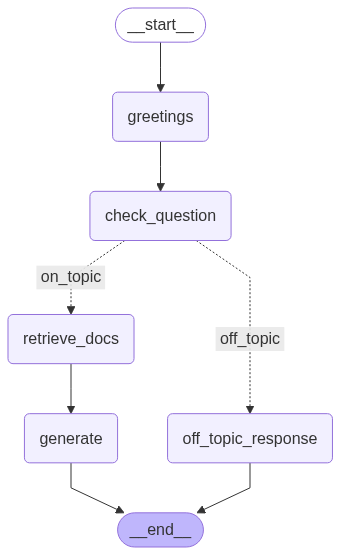

In [50]:
#Preview the workflow
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

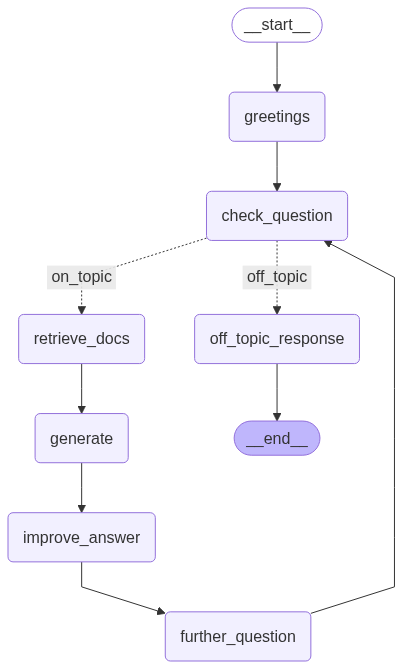

In [70]:
# Display the workflow graph for visualization
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [71]:
result = app.invoke({"start": True}, {'recursion_limit': 50})

Hello! Welcome to the restaurant. I will be your waiter. How can I help you?
What do you recommend?


I highly recommend the Siao Long Pao, available in both traditional and black variations; they're delightful dumplings filled with a mix of pork, paksoy, and shiitake mushrooms. For something lighter, the Vegetarian Soup is also an excellent choice; it's flavorful and refreshing. If you're in the mood for something crunchy, I suggest trying the Gyoza or the Fortune Bags; they're both very popular with our guests. Would you like more information about any of these dishes or assistance with anything else?


What do you have for non vegetarian items?


For non-vegetarian options, we offer the Siao Long Pao in both traditional and black varieties, filled with pork, paksoy, and shiitake mushrooms. You might also enjoy the Gyozas, which are available with shrimp, duck, or chicken. The Cha Siu Pao is a delicious steamed bun stuffed with BBQ pork, while the Har Kau features shrimp and bamboo. 

KeyboardInterrupt: Interrupted by user